# トピック分析


In [2]:
import os
import nltk
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from tqdm import tqdm
from pyvis.network import Network
from book import *
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.models.ldamodel import CoherenceModel
from labMTsimple.storyLab import *
from nltk.corpus import stopwords
from igraph import *
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from wordcloud import WordCloud
from collections import defaultdict


In [3]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tomoya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
DATA = 'data/'
DIST = 'dist/min/'
TMP = 'tmp/min/'
TEXT = 'text/'
PICKLE = 'pickle/'
MODEL = 'model/'

SRC = 'sources.txt'
TEST = 'sources-test.txt'
MIN_TEXT = 'texts-min.txt'

FILTER_TOKENS = ['\'', 'mrs', 'mr']
NUM_TOPICS = 16
NO_BELOW = 3
NO_ABOVE = 0.7


In [5]:
sns.set(style='darkgrid')


In [6]:
labMT, labMTvector, labMTwordlist = emotionFileReader(returnVector=True)


In [7]:
def get_pairs(array):
    pairs = []
    for i, v1 in enumerate(array):
        for j, v2 in enumerate(array):
            if i != j:
                pairs.append((v1, v2))
    return pairs


In [8]:
def load_array(file, delim=None, cnt=None):
    with open(file, 'r', encoding="utf-8") as f:
        if cnt:
            array = [[elem.strip() for elem in line.split(delim, cnt)]
                      for line in f.readlines()]
        else:
            array =  [[elem.strip() for elem in line.split(delim)]
                    for line in f.readlines()]
    return array


def fprint_array(file_name, array):
    with open(file_name, 'w', encoding="utf-8") as f:
        for vector in array:
            for elem in vector:
                f.write('{:10} '.format(elem))
            f.write('\n')


In [9]:
infos = load_array(DATA + SRC, ',', 2)
pprint(infos[:10])


[['12', '12-cleaned.txt', 'Through the Looking-Glass'],
 ['16', '16-cleaned.txt', 'Peter Pan'],
 ['20', '20-cleaned.txt', 'Paradise Lost'],
 ['21', '21-cleaned.txt', 'Aesop’s Fables'],
 ['24', '24-cleaned.txt', 'O Pioneers!'],
 ['32', '32-cleaned.txt', 'Herland'],
 ['36', '36-cleaned.txt', 'The War of the Worlds'],
 ['41', '41-cleaned.txt', 'The Legend of Sleepy Hollow'],
 ['47', '47-cleaned.txt', 'Anne Of Avonlea'],
 ['51', '51-cleaned.txt', 'Anne Of The Island']]


In [10]:
def calc_happiness(window):
    return emotion(window, labMT)


In [11]:
books = {}
for book_id, file_name, title in tqdm(infos):
    FILE = TMP + PICKLE + '{}.pickle'.format(book_id)
    book = Book(book_id, title, file_name)
    if not os.path.exists(FILE):
        try:
            book.load()
            book.windowed()
            book.calc_happiness(calc_happiness)
            books[int(book_id)] = book
            with open(FILE, 'wb') as f:
                pickle.dump(book, f)
        except BookLoadingException as err:
            pass
    else:
        with open(FILE, 'rb') as f:
            books[int(book_id)] = pickle.load(f)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1244/1244 [00:55<00:00, 22.53it/s]


In [12]:
print(len(books))


1149


In [13]:
def get_min_window(book):
    happinesses = book.happinesses()
    i = happinesses.index(min(happinesses))
    local_array = []
    local_array.append(i)
    for word in book.windows()[i].split():
        local_array.append(word)
    return local_array


In [14]:
MIN_TEXT_PATH = TMP + MIN_TEXT
if not os.path.exists(MIN_TEXT_PATH):
    min_windows = [get_min_window(books[book_id]) for book_id in books]
    fprint_array(MIN_TEXT_PATH, min_windows)
else:
    min_windows = load_array(MIN_TEXT_PATH)
min_windows = [array[1:] for array in min_windows]


In [15]:
print(len(min_windows))
print(len(min_windows[0]))


1159
10000


## モデルの構築


In [16]:
stopset = set(stopwords.words('english'))


In [17]:
def get_stop_words(dic):
    return [dic[word] for word in dic if len(word) < 3 or word in stopset or 
            word not in labMT]


In [18]:
DICTIONARY_PATH = TMP + 'dictionary.dict'
if os.path.exists(DICTIONARY_PATH):
    dictionary = Dictionary.load(DICTIONARY_PATH)
else:
    dictionary = Dictionary(min_windows)
    dictionary.filter_extremes(no_below=NO_BELOW, no_above=NO_ABOVE)
    dictionary.filter_tokens(bad_ids=get_stop_words(dictionary.token2id))
    dictionary.save(DICTIONARY_PATH)


In [19]:
corpus = [dictionary.doc2bow(text) for text in min_windows]


In [20]:
MODEL_FOLDER = TMP + MODEL
if not os.path.exists(MODEL_FOLDER):
    os.makedirs(MODEL_FOLDER)

models = {}

for topic_num in tqdm(range(2, NUM_TOPICS)):
    MODEL_PATH = MODEL_FOLDER + 'topic-{}.model'.format(topic_num)
    if not os.path.exists(MODEL_PATH):
        lda_model = LdaModel(corpus=corpus, num_topics=topic_num, id2word=dictionary)
        lda_model.save(MODEL_PATH)
    else:
        lda_model = LdaModel.load(MODEL_PATH)
    models[topic_num] = lda_model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 18.78it/s]


## テストデータで分析


In [21]:
TEST_PATH = DATA + TEST
test_infos = load_array(TEST_PATH, ',', 2)
pprint(test_infos[:10])


[['37332', '37332-cleaned.txt', 'A Little Princess'],
 ['43', '43-cleaned.txt', 'The Strange Case Of Dr. Jekyll And Mr. Hyde'],
 ['11', '11-cleaned.txt', "Alice's Adventures in Wonderland"],
 ['98', '98-cleaned.txt', 'A Tale of Two Cities'],
 ['1974', '1974-cleaned.txt', 'Poetics'],
 ['45', '45-cleaned.txt', 'Anne of Green Gables'],
 ['119', '119-cleaned.txt', 'A Tramp Abroad'],
 ['205', '205-cleaned.txt', 'Walden, and On The Duty Of Civil Disobedience'],
 ['752', '752-cleaned.txt', 'A Young Girl’s Diary'],
 ['901', '901-cleaned.txt', 'The Jew of Malta']]


In [22]:
test_books = {}
for book_id, file_name, title in tqdm(test_infos):
    FILE = TMP + PICKLE + '{}.pickle'.format(book_id)
    if not os.path.exists(FILE):
        try:
            book = Book(book_id, title, file_name)
            book.load()
            book.windowed()
            book.calc_happiness(calc_happiness)
            test_books[int(book_id)] = book
            with open(FILE, 'wb') as f:
                pickle.dump(book, f)
        except BookLoadingException as err:
            pass
            
    else:
        with open(FILE, 'rb') as f:
            test_books[int(book_id)] = pickle.load(f)
print(len(test_books))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 17.38it/s]


15


In [23]:
test_windows = []
labels = []
for book_id in test_books:
    book = test_books[book_id]
    window = get_min_window(book)[1:]
    test_windows.append(window)
    labels.append(book.title())
test_dictionary = Dictionary(test_windows)
test_dictionary.filter_extremes(no_below=NO_BELOW, no_above=NO_ABOVE)
test_dictionary.filter_tokens(bad_ids=get_stop_words(test_dictionary.token2id))
test_corpus = [test_dictionary.doc2bow(text) for text in test_windows]


In [24]:
test_texts = []
for doc in test_corpus:
    text = []
    for word in doc:
        for i in range(int(word[1])):
            text.append(test_dictionary[word[0]])
    test_texts.append(text)


In [25]:
for max_topic in range(3, NUM_TOPICS):
    model = models[max_topic]
    score_by_topic = defaultdict(int)
    topic_array = [[0.0 for j in range(max_topic)] for i in range(len(labels))]
    for index, unseen_doc in enumerate(test_corpus):
        for topic, score in model[unseen_doc]:
            topic_array[index][int(topic)] = float(score)
    df = pd.DataFrame(topic_array)
    df.to_excel(DIST + '{}.xlsx'.format(max_topic))


## トピック数の決定


### Perplexityによる評価


In [26]:
perplexities = []
for max_topic in range(3, NUM_TOPICS):
    model = models[max_topic]
    perwordbound = model.log_perplexity(corpus)
    perplexities.append([max_topic, np.exp2(-perwordbound)])
fprint_array(DIST + 'perplexity.txt', perplexities)


### Coherenceによる評価


In [27]:
coherences = []
for num_topics in range(3, NUM_TOPICS):
    model = models[num_topics]
    cohsum = 0.0
    for coherence in model.top_topics(corpus=test_corpus):
        cohsum += coherence[1]
    coherences.append([num_topics, cohsum / num_topics])
fprint_array(DIST + 'coherences.txt', coherences)


### KL Divergenceによる評価


In [28]:
def kl(p_dict, q_dict):
    distance = 0.0
    for word in p_dict:
        if word in q_dict:
            distance += p_dict[word] * np.log(p_dict[word] / q_dict[word])
    return distance


In [29]:
kl_distances = []
for num_topics in tqdm(range(3, NUM_TOPICS)):
    model = models[num_topics]
    pairs = get_pairs(range(num_topics))
    distance = 0.0
    for a, b in pairs:
        p = {t[0]: t[1] for t in model.get_topic_terms(a)}
        q = {t[0]: t[1] for t in model.get_topic_terms(b)}
        pq = kl(p, q)
        distance += pq
    kl_distances.append(distance / len(pairs))
pprint(kl_distances)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 28.34it/s]


[0.0010426320180461819,
 0.0009625168219524008,
 0.0011683437624014914,
 0.0010344299680355106,
 0.0010387186521689901,
 0.0011750095884833303,
 0.0013710606336366658,
 0.0012278616431406894,
 0.0015437051206990046,
 0.0011047779844754284,
 0.0014098621262638423,
 0.0013855580713966248,
 0.0013063305017973496]


### 各評価のグラフ


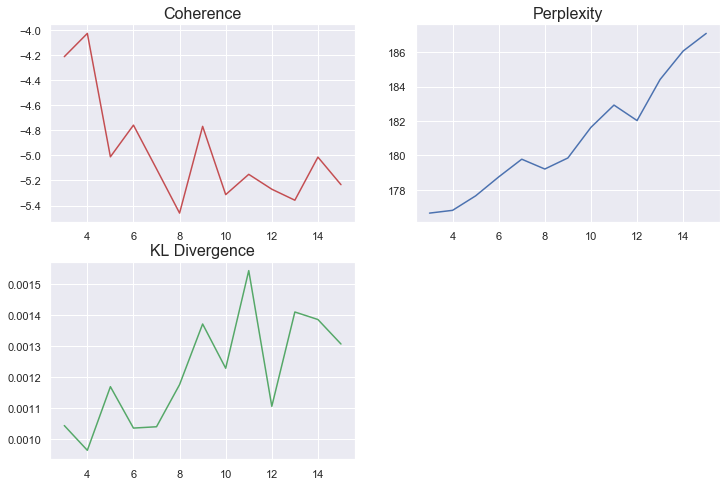

In [30]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)

ax1.plot(range(3, NUM_TOPICS), [a[1] for a in coherences], color='r')
ax2.plot(range(3, NUM_TOPICS), [perplexity[1] for perplexity in perplexities], color='b')
ax3.plot(range(3, NUM_TOPICS), kl_distances, color='g')

ax1.set_title('Coherence', fontsize=16)
ax2.set_title('Perplexity', fontsize=16)
ax3.set_title('KL Divergence', fontsize=16)

plt.savefig(DIST + 'result.png')
plt.show()


### トピック数4と11の関連する単語


In [31]:
focus = 4
a = []
for i in range(focus):
    words = models[focus].show_topic(i, topn=15)
    pprint(models[focus].show_topic(i, topn=3))
    a.append([i] + [word[0] for word in words])
fprint_array(DIST + 'topics-{}.txt'.format(focus), a)


[('king', 0.007447943), ('god', 0.0060737603), ('father', 0.005253976)]
[('god', 0.005073689), ('woman', 0.004124617), ('king', 0.0039102035)]
[('nature', 0.004934394), ('love', 0.004849532), ('god', 0.0043665203)]
[('love', 0.005474302), ('god', 0.004148383), ('woman', 0.0037201762)]


In [32]:
focus = 11
a = []
for i in range(focus):
    words = models[focus].show_topic(i, topn=15)
    pprint(models[focus].show_topic(i, topn=3))
    a.append([i] + [word[0] for word in words])
fprint_array(DIST + 'topics-{}.txt'.format(focus), a)


[('god', 0.0073798867), ('yes', 0.0040406976), ('mother', 0.0040246733)]
[('miss', 0.006556173), ('illustration', 0.0057739327), ('yes', 0.005472609)]
[('king', 0.012741802), ('god', 0.005236742), ('war', 0.004630722)]
[('love', 0.006933766), ('father', 0.005185605), ('mother', 0.0048810085)]
[('king', 0.004682851), ('yes', 0.0038881742), ('love', 0.0037743992)]
[('love', 0.004603712), ('father', 0.004436779), ('war', 0.003827168)]
[('god', 0.0074738804), ('king', 0.0058161174), ('father', 0.0052085156)]
[('god', 0.005787872), ('love', 0.0052993787), ('yes', 0.004449993)]
[('love', 0.0052634287), ('woman', 0.004882324), ('illustration', 0.0040185577)]
[('god', 0.0058460026), ('woman', 0.0049648923), ('king', 0.004938916)]
[('yes', 0.0061846306), ('love', 0.004805655), ('war', 0.0038861735)]


## クラスタリング


### トピック数4によるクラスタリング


In [33]:
df = pd.read_excel(DIST + '4.xlsx')
array = [a[1:] for a in df.values]
pprint(array[:10])


[array([0.11202957, 0.51322424, 0.07166604, 0.30308014]),
 array([0.13052814, 0.14020114, 0.27309239, 0.45617834]),
 array([0.2280961 , 0.20052752, 0.33537081, 0.23600554]),
 array([0.22681153, 0.2682485 , 0.15504307, 0.34989694]),
 array([0.21331912, 0.37207094, 0.16201288, 0.25259706]),
 array([0.09624927, 0.31056187, 0.19633244, 0.39685643]),
 array([0.08416138, 0.14578407, 0.42510691, 0.34494764]),
 array([0.23260385, 0.14693898, 0.17388527, 0.44657186]),
 array([0.32445487, 0.19715227, 0.17332473, 0.30506808]),
 array([0.38461298, 0.26889166, 0.22377256, 0.12272285])]


In [34]:
# arrayをベクトルごとに正規化する
vectors = [a / np.linalg.norm(a) for a in array]
pprint(vectors[:10])


[array([0.18344727, 0.8403994 , 0.1173524 , 0.4962906 ]),
 array([0.23097005, 0.24808646, 0.48323805, 0.80720935]),
 array([0.44697984, 0.39295612, 0.65719664, 0.46247928]),
 array([0.43660658, 0.51637172, 0.29845407, 0.67354295]),
 array([0.40752875, 0.71081111, 0.30951235, 0.48256604]),
 array([0.17521484, 0.56535544, 0.35740902, 0.72244846]),
 array([0.14694298, 0.25453415, 0.7422226 , 0.60226716]),
 array([0.42093221, 0.26590854, 0.31467197, 0.80814001]),
 array([0.62762045, 0.38136828, 0.33527667, 0.59011893]),
 array([0.71998532, 0.50335808, 0.4188963 , 0.22973393])]


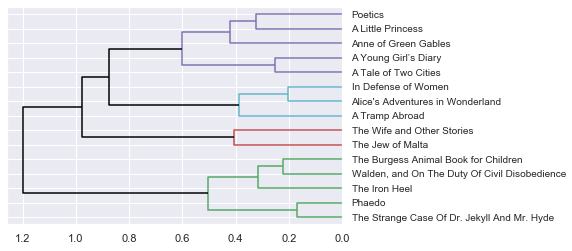

In [35]:
Z = linkage(vectors, method='ward')
dendrogram(Z, 
           labels=[a[2]for a in test_infos],
           leaf_font_size=10.,
           above_threshold_color='black', 
           orientation='left')
plt.savefig(DIST + 'dendrogram-4.png')
plt.show()


In [36]:
c = fcluster(Z, 0.7*max(Z[:,2]), criterion='distance')
pprint(c)


array([4, 1, 3, 4, 4, 4, 3, 1, 4, 2, 1, 3, 1, 2, 1], dtype=int32)


In [37]:
cls_map = {}
for info, cls in zip(test_infos, c):
    if cls not in cls_map:
        cls_map[cls] = []
    cls_map[cls].append(info[2])


In [38]:
with open(DIST + 'topic-4.txt', 'w', encoding='utf-8') as f:
    for cls in cls_map:
        f.write('{}:\n'.format(cls))
        for title in cls_map[cls]:
            f.write('\t{}\n'.format(title))


### トピック数11によるクラスタリング


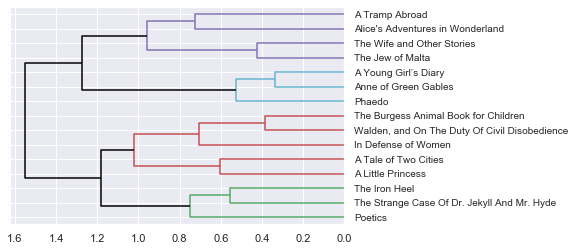

In [39]:
df = pd.read_excel(DIST + '11.xlsx')
array = [a[1:] for a in df.values]

# arrayをベクトルごとに正規化する
vectors = [a / np.linalg.norm(a) for a in array]

Z = linkage(vectors, method='ward')
dendrogram(Z,
           labels=[a[2]for a in test_infos],
           leaf_font_size=10.,
           above_threshold_color='black', 
           orientation='left')

c = fcluster(Z, 0.7*max(Z[:,2]), criterion='distance')

cls_map = {}
for info, cls in zip(test_infos, c):
    if cls not in cls_map:
        cls_map[cls] = []
    cls_map[cls].append(info[2])

with open(DIST + 'topic-11.txt', 'w', encoding='utf-8') as f:
    for cls in cls_map:
        f.write('{}:\n'.format(cls))
        for title in cls_map[cls]:
            f.write('\t{}\n'.format(title))
plt.savefig(DIST + 'dendrogram-11.png')
plt.show()


## Word Cloudによる可視化
